In [20]:
%load_ext autoreload
%autoreload
import torch
import torch.nn as nn
from collections import OrderedDict

from datasets.kitti_raw_monosf import KITTI_Raw_EigenSplit_Train, KITTI_Raw_EigenSplit_Valid
from datasets.kitti_2015_train import KITTI_2015_MonoSceneFlow_Full

from models.Model import Model
from models.JointModel import JointModel
from losses import Loss

from augmentations import Augmentation_Resize_Only
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from pprint import pprint
from tqdm import tqdm
    
class Args:
    cuda = True
    use_bn = False
    momentum = 0.9
    beta = 0.999
    weight_decay=0.0
    train_exp_mask=False
    train_census_mask=True
    model_name = "joint"
    encoder_name='pwc'
    disp_pts_w = 0.0
    flow_pts_w = 0.2
    sf_sm_w = 200
    disp_sm_w = 0.2
    do_pose_c2f = False
    ssim_w = 0.85
    disp_smooth_w = 0.1
    mask_reg_w = 0.0
    num_examples = 200
    static_cons_w = 0.0
    flow_reduce_mode = 'sum'
    mask_cons_w = 0.3
    mask_sm_w = 0.1
    batch_size = 1
    flow_diff_thresh = 0.15
    pt_encoder = False
    num_scales = 4
    evaluation = True
    use_disp_min = False
    apply_flow_mask = True
    apply_mask = True 
    mask_thresh = 0.5
    use_bottleneck = False
    flow_sm_w = 200
    flow_cycle_w = 0.0
    use_static_mask = False
    disp_lr_w = 0.0

args = Args()

model = JointModel(args).cuda()

state_dict = torch.load('pretrained/pose_corr.ckpt')['model']
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:]
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)
model = model.eval()

del state_dict
del new_state_dict

augmentation = Augmentation_Resize_Only(args).cuda()
# loss = Loss(args).cuda()

# val_dataset = KITTI_2015_MonoSceneFlow_Full(args, root='/external/datasets/kitti2015/')
val_dataset = KITTI_Raw_EigenSplit_Train(args, root='/external/datasets/kitti_data_jpg/', flip_augmentations=False, num_examples=500)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=2, pin_memory=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
%autoreload 

outs = []

for i, data in tqdm(enumerate(val_loader)):
    with torch.no_grad():
        # Get input and target tensor keys
        input_keys = list(filter(lambda x: "input" in x, data.keys()))
        target_keys = list(filter(lambda x: "target" in x, data.keys()))
        tensor_keys = input_keys + target_keys
        
        # Possibly transfer to Cuda
        for k, v in data.items():
            if k in tensor_keys:
                data[k] = v.cuda(non_blocking=True)
                
        aug_data = augmentation(data)
        out = model(aug_data)
        
        ds = {
            'disps_l2_pp': out['disps_l2_pp'][0],
            'pose_b': out['pose_b'][0],
            'flows_b_pp': out['flows_b_pp'][0],
            'K': aug_data['input_k_l1_aug'],
            'img_l2': aug_data['input_l2'],
            'masks_l2_pp': out['masks_l2_pp'][0]
            }
                
        outs.append(ds)

250it [01:29,  2.79it/s]


In [31]:
import numpy as np
import torch.nn.functional as tf
from utils.flow import flow_to_png_middlebury
from utils.loss_utils import _disp2depth_kitti_K
from utils.helpers import BackprojectDepth, Project3D
from utils.inverse_warp import pose2sceneflow

depth_imgs = []
pose_imgs = []
sf_imgs = []
img_l2s = []
mask_imgs = []

for out in tqdm(outs):
    img_l2 = out['img_l2']
    disp_l2 = out['disps_l2_pp']
    mask_l2 = out['masks_l2_pp']
    pose_b = out['pose_b']
    flow_b = out['flows_b_pp']
    K = out['K']
    inv_K = torch.inverse(K)

    b, _, h, w = flow_b.shape

    backproj = BackprojectDepth(b, h, w)
    proj = Project3D(b, h, w)

    disp_l2 = disp_l2 * w
    depth_l2 = _disp2depth_kitti_K(disp_l2, K[:, 0, 0])
    
    depth_l2 = tf.interpolate(depth_l2, [h//2, w//2], align_corners=True, mode='bilinear')
    
    cmap = plt.get_cmap('magma')
    
    depth_img = cmap(depth_l2[0].squeeze(dim=1).cpu().numpy().astype(np.uint8), bytes=True).squeeze()[:, :, :-1]
    depth_imgs.append(depth_img)
    
    depth_img = cmap(depth_l2[1].squeeze(dim=1).cpu().numpy().astype(np.uint8), bytes=True).squeeze()[:, :, :-1]
    depth_imgs.append(depth_img)
    
    #mask
    mask_l2 = tf.interpolate(mask_l2, [h//2, w//2], align_corners=True, mode='bilinear')
    mask_img = cmap(mask_l2[0].squeeze(dim=1).cpu().numpy().astype(np.uint8), bytes=True).squeeze()[:, :, :-1]
    mask_imgs.append(mask_img)
    
    mask_img = cmap(mask_l2[1].squeeze(dim=1).cpu().numpy().astype(np.uint8), bytes=True).squeeze()[:, :, :-1]
    mask_imgs.append(mask_img)

    # pose
    pose_flow = pose2sceneflow(depth_l2, None, inv_K, pose_mat=pose_b)
    pose_flow = tf.interpolate(pose_flow, [h//2, w//2], align_corners=True, mode='bilinear')
    
    pose_img = flow_to_png_middlebury(pose_flow[0].cpu().numpy())
    pose_imgs.append(pose_img)
    pose_img = flow_to_png_middlebury(pose_flow[1].cpu().numpy())
    pose_imgs.append(pose_img)

    # sf
    flow_b = tf.interpolate(flow_b, [h//2, w//2], align_corners=True, mode='bilinear')
    
    sf_img = flow_to_png_middlebury(flow_b[0].cpu().numpy())
    sf_imgs.append(sf_img)
    sf_img = flow_to_png_middlebury(flow_b[1].cpu().numpy())
    sf_imgs.append(sf_img)
    
    img = tf.interpolate(img_l2, [h//2, w//2], align_corners=True, mode='bilinear').permute(0, 2, 3, 1)
    
    img_l2s.append((img[0].cpu().numpy() * 255).astype(np.uint8))
    img_l2s.append((img[1].cpu().numpy() * 255).astype(np.uint8))

100%|██████████| 250/250 [00:07<00:00, 34.92it/s]


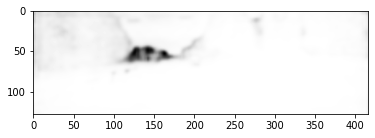

In [38]:
plt.imshow(mask_l2.cpu()[0].squeeze(), cmap='gray')

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import imageio

num_frames = len(depth_imgs)
fps = 15 

frames = []
for (i, d, p, s, m) in tqdm(zip(img_l2s, depth_imgs, pose_imgs, sf_imgs, mask_imgs)):
    frame = np.zeros((384, 832, 3)).astype(np.uint8)
    frame[0*128: 1*128, 0*416: 1*416, :] = i
    frame[1*128: 2*128, 0*416: 1*416, :] = d
    frame[2*128: 3*128, 0*416: 1*416, :] = m
    frame[0*128: 1*128, 1*416: 2*416, :] = p
    frame[1*128: 2*128, 1*416: 2*416, :] = s
    frames.append(frame)

imageio.mimwrite('frames_ds.gif', frames, format='gif', fps=fps)

500it [00:00, 537.21it/s]
